# Initialize the Database

In [ ]:
'''
created by @asha
march 8th 2019
'''

In [1]:
# Let's start by initializing the database
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np

nusc = NuScenes(version='v0.1', dataroot='data/nuscenes', verbose=True)

Loading NuScenes tables for version v0.1 ...
23 category,
8 attribute,
5 visibility,
6975 instance,
12 sensor,
1200 calibrated_sensor,
304715 ego_pose,
12 log,
100 scene,
3977 sample,
304715 sample_data,
99952 sample_annotation,
12 map,
Done loading in 11.9 seconds.
Reverse indexing ...
Done reverse indexing in 3.8 seconds.


Categories that are annotated

In [2]:
# The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. 
# For example the first record of the category table is stored at

#nusc.category[0]['name']

#these are the categories available
cat = []
for i in range(len(nusc.category)):
    print(nusc.category[i]['name'])
    cat.append(nusc.category[i]['name'])



human.pedestrian.adult
human.pedestrian.child
human.pedestrian.wheelchair
human.pedestrian.stroller
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.construction_worker
animal
vehicle.car
vehicle.motorcycle
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.truck
vehicle.construction
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.trailer
movable_object.barrier
movable_object.trafficcone
movable_object.pushable_pullable
movable_object.debris
static_object.bicycle_rack


# classes that we are detecting :

We merge adult, child, police officer, construction worker into a single class called pedestrian
We are detecting: 
- pedestrian
- car 
- bicycle

In [3]:
classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
pedestrians = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker'] 

In [4]:
print('Total number of samples')
print(len(nusc.sample))

total_no_of_samples = len(nusc.sample)

#print('Total number of images')
#print(len(nusc.sample*6)) #6 different cameras

Total number of samples
3977


# Functions

Defined the following function:

- get_sample_data (edit of nutonomy's original nusc.get_sample_data)
        
        input:(nusc, sample_data_token)
        output:path to the data, lists of 3d bounding boxes in the image (in camera coordinates), 
        annotation token of annotations in the image, intrinsic matrix of the camera)
        

- threeD_to_2D
         
        input: (box (camera coordinates),intrinsic matrix))
        output : corners of the 2d bounding box in image plane

- all_3d_to_2d(boxes,anns,intrinsic)

        input : boxes in camera coordinates, list of annotation tokens of annotations in the image, 
        intrinsic matrix
        output: x_min,x_max,y_min,y_max,width,height of the 2D boundings boxes of objects that are
        more than 40% visible in panoramic view of all cameras, also ensures that the center of the 
        bounding boxes falls inside the image

- extract_bounding_box(i):
        
        input: sample number
        output: min x, max x, min y max y, width and height of bounding box in image coordinates 
        2d bounding box of objects which are 40% visible in panoramic view of all cameras and center 
        falls witin the image



In [5]:
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import quaternion_slerp, box_in_image, BoxVisibility
import numpy as np
def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info

In [6]:
def threeD_2_twoD(boxsy,intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    

    
    return min_x,max_x,min_y,max_y



def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]
    
   
    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]
        
        if box.name in classes: #if the box.name is in the classes we want to detect
        
            if box.name in pedestrians: 
                orig_objects_detected.append("pedestrian")
            elif box.name == "vehicle.car":
                orig_objects_detected.append("car")
            else:
                orig_objects_detected.append("cyclist")
            #print(box)
            
            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token'] #give annotation key
            visibility = int(visibility)

            
            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras

                    
                center = box.center #get boxe's center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2]) #convert center point into image plane
                
                
                
                
                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass
                
                else:
                    min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
                    w = max_x - min_x
                    h = max_y - min_y
        
        
                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)
                    width.append(w)
                    height.append(h)
                    if box.name in pedestrians: 
                        objects_detected.append("pedestrian")
                    elif box.name == "vehicle.car":
                        objects_detected.append("car")
                    else:
                        objects_detected.append("cyclist")
                    

            else:
                pass

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected #for a single image

In [7]:
def extract_bounding_box(i,camera_name): #give a single sample number and camera name
    
    '''
    input sample number i, camera name
    outputs min x, max x, min y max y, width and height of bounding box in image coordinates
    2d bounding box
    options for camera name : CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT,CAM_BACK_LEFT
    '''
    
    nusc.sample[i] #one image
    
    camera_token = nusc.sample[i]['data']['%s' %camera_name] #one camera, get the camera token 

    path, boxes, anns, intrinsic_matrix = get_sample_data(nusc,'%s' %camera_token) #gets data for one image
    
    x_min, x_max,y_min,y_max,width,height, objects_detected,orig_objects_detected = all_3d_to_2d(boxes,anns, intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes,intrinsic_matrix, objects_detected,orig_objects_detected
    #info for a single image
    

In [8]:
#Create target Directory if don't exist
import os.path
def create_annotation_directory(camera):
    current_dir =os.getcwd()
    #current_dir ="%s/annotation" %pwd
    dirName ="%s/annotation/%s_anno" %(current_dir,camera)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")

In [ ]:
create_annotation_directory(camera)

In [9]:
from lxml import etree as ET
def write_xml_annotation(x_min,x_max,y_min,y_max,width,height,path,boxes,objects_detected): #single image info
    #detected_items =[]
    #import xml.etree.cElementTree as ET
    path_split = path.split("/")
    full_image_name = path_split[-1]
    name =full_image_name.split(".")[0]
    
    root = ET.Element("annotation")


    ET.SubElement(root, "folder").text = "%s" %camera
    ET.SubElement(root, "filename").text = "%s" %full_image_name
    ET.SubElement(root, "path").text = "%s" %path

    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "nuTonomy-nuscenes"

    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text="1600"
    ET.SubElement(size,"height").text="900"
    ET.SubElement(size,"depth").text="3"
    ET.SubElement(root, "segmented").text = "0"

    for j in range(len(objects_detected)): #
        
        ob= ET.SubElement(root, "object")
        ET.SubElement(ob,"name").text="%s" %objects_detected[j]
        ET.SubElement(ob,"pose").text="Unspecified"
        ET.SubElement(ob, "truncated").text="truncated"
        ET.SubElement(ob, "difficult").text="0"

        bb = ET.SubElement(ob,"bndbox")
        ET.SubElement(bb,"xmin").text="%s" %x_min[j]
        ET.SubElement(bb,"ymin").text="%s" %y_min[j]
        ET.SubElement(bb,"xmax").text="%s" %x_max[j]
        ET.SubElement(bb,"ymax").text="%s" %y_max[j]
        
 
    filename = "%s/%s.xml" %(dirName,name)
    tree = ET.ElementTree(root)
    #tree.write("%s/%s.xml" %(dirName,name),pretty_print=True)
    tree.write("%s" %filename, pretty_print=True)
    
    return filename #file a single file
    

In [10]:
def extract_data(filename,dirName): #extract info from a single file

    objects_detected =[]
    x_min=[]
    x_max=[]
    y_min=[]
    y_max=[]
    width=[]
    height=[]


    
    tree = ET.parse('%s' %(filename))  
    root = tree.getroot()



    for objs in root.findall('object'):
        #print("yolo")
        name = objs.find('name').text
        objects_detected.append(name)
    
        for bbs in objs.findall('bndbox'):
        
            xmin = bbs.find('xmin').text
            x_min.append(float(xmin))
        
            xmax = bbs.find('xmax').text
            x_max.append(float(xmax))
        
            ymin = bbs.find('ymin').text
            y_min.append(float(ymin))
        
            ymax = bbs.find('ymax').text
            y_max.append(float(ymax))
        
        
            w = float(xmax) - float(xmin)
            h = float(ymax) - float(ymin)
        
            width.append(w)
            height.append(h)

    return width,height,objects_detected

In [11]:
camera_names =['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_FRONT_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT', 'CAM_BACK_LEFT']
i = 0
detected_items =[]
orig_detected_items=[]
obs = []

file=[]

for camera in camera_names: #iterate through all cameras
    print(camera)
    create_annotation_directory(camera)
    current_dir =os.getcwd()
    dirName ="%s/annotation/%s_anno" %(current_dir,camera) #current directory's name
    #we are looking at one camera now
    for sample_number in range(total_no_of_samples):#look at a single image
        #print(sample_number)
        #get in for a single image
        
        x_min, x_max,y_min,y_max,width,height, path, boxes, intrinsic_matrix,objects_detected,orig_objects_detected = extract_bounding_box(sample_number, '%s' %camera) 
        filename = write_xml_annotation(x_min,x_max,y_min,y_max,width,height,path,boxes,objects_detected)
         
        #if sample_number !=0 :
            #if file[-1] == filename:
                #print(sample_number)
        
        file.append(filename)
        

        #print
        #print(filename)
        
        widthsy, heightsy, objects_detectedsy = extract_data(filename,dirName)
        
        assert objects_detected == objects_detectedsy

        
        
        detected_items = detected_items + objects_detected
        orig_detected_items= orig_detected_items + orig_objects_detected
        obs = obs + objects_detectedsy
        #if len(x_min) ==0:
            
            #i = i+1
        
        

CAM_FRONT
Directory  /Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/annotation/CAM_FRONT_anno  already exists
CAM_FRONT_RIGHT
Directory  /Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/annotation/CAM_FRONT_RIGHT_anno  already exists
CAM_FRONT_LEFT
Directory  /Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/annotation/CAM_FRONT_LEFT_anno  already exists
CAM_BACK
Directory  /Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/annotation/CAM_BACK_anno  already exists
CAM_BACK_RIGHT
Directory  /Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/annotation/CAM_BACK_RIGHT_anno  already exists
CAM_BACK_LEFT
Directory  /Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/annotation/CAM_BACK_LEFT_anno  already exists


In [ ]:
print(len(obs))
print(len(orig_detected_items))

print(len(file))

unique = list(set(file))
print(len(unique))

print('total number of files')
3962*6

In [12]:
print(len(file))
#print(len(unique))

for i in range(len(file)):
    check = file[i]
    
    for j in range(len(file)):
        if j !=i :
            if check == file[j]:
                print(i)
                print(j)
                print('katie')

23862
343
369
katie
344
370
katie
345
371
katie
346
372
katie
347
373
katie
348
374
katie
349
375
katie
350
376
katie
351
377
katie
352
378
katie
353
379
katie
354
380
katie
355
381
katie
356
382
katie
357
383
katie
369
343
katie
370
344
katie
371
345
katie
372
346
katie
373
347
katie
374
348
katie
375
349
katie
376
350
katie
377
351
katie
378
352
katie
379
353
katie
380
354
katie
381
355
katie
382
356
katie
383
357
katie
4320
4346
katie
4321
4347
katie
4322
4348
katie
4323
4349
katie
4324
4350
katie
4325
4351
katie
4326
4352
katie
4327
4353
katie
4328
4354
katie
4329
4355
katie
4330
4356
katie
4331
4357
katie
4332
4358
katie
4333
4359
katie
4334
4360
katie
4346
4320
katie
4347
4321
katie
4348
4322
katie
4349
4323
katie
4350
4324
katie
4351
4325
katie
4352
4326
katie
4353
4327
katie
4354
4328
katie
4355
4329
katie
4356
4330
katie
4357
4331
katie
4358
4332
katie
4359
4333
katie
4360
4334
katie
8297
8323
katie
8298
8324
katie
8299
8325
katie
8300
8326
katie
8301
8327
katie
8302
8328
kati

In [ ]:
import os.path
from os import listdir
import xml.etree.ElementTree as ET  
camera_names =['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_FRONT_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT', 'CAM_BACK_LEFT']

def list_of_files(camera):
    current_dir =os.getcwd()
    #current_dir ="%s/annotation" %pwd
    
    dirName ="%s/annotation/%s_anno" %(current_dir,camera)
    files = os.listdir(dirName)
    
    return files, dirName, current_dir

In [ ]:
total_objects_detected =[]
for camera in camera_names:
    files, dirName,current_dir = list_of_files(camera)
    print(dirName)
    
    for f in files:
        name_of_file = '%s/%s' %(dirName, f)
        #print(name_of_file)
        w,h,od = extract_data(name_of_file,dirName)
        total_objects_detected = total_objects_detected + od
        #print(od)
        #print(od)
        

In [ ]:
print(len(total_objects_detected))
print(len(detected_items))

In [ ]:
print(orig_detected_items.count('car'))
print(orig_detected_items.count('pedestrian'))
print(orig_detected_items.count('cyclist'))


add = orig_detected_items.count('car') + orig_detected_items.count('pedestrian') + orig_detected_items.count('cyclist')
print(add)

In [ ]:
import os
print(os.getcwd())

In [ ]:
#print(len(detected_items))
print('Total number of car annotations:')
print(detected_items.count('car'))
print('Total number of pedestrian annotations')
print(detected_items.count('pedestrian'))
print('Total number of cyclist annotations')
print(detected_items.count('cyclist'))

add = detected_items.count('car') + detected_items.count('pedestrian') + detected_items.count('cyclist')
print(add)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('/Volumes/Luthor/nutonomy/nuscenes-devkit-master/python-sdk/%s' %path), dtype=np.uint8)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
# Create figure and axes


# Display the image
ax.imshow(im)
#

#print(x)
#print(y)
#print(width)
#print(height)
#print(center_point[0])
#print(center_point[1])

#width = max_x-min_x
#height = max_y-min_y
#for i in range(len(perspective_x)):
#ax.plot(center_point[0], center_point[1], marker ='o', color='b', markersize =30)
#ax.plot(perspective_x[i], perspective_y[i], marker ='o', color='b', markersize =10)
#ax.plot(r2c2[0], r2c2[1], marker ='o', color='b', markersize =10)
#ax.plot(min_x, min_y, marker ='o', color='b', markersize =10)
#ax.plot(max_x, max_y, marker ='o', color='b', markersize =10)

for i in range(len(x_min)):
    if objects_detected[i] =='pedestrian':
        col = 'red'
    elif objects_detected[i] =='car':
        col ='green'
    else:
        col= 'blue'
    rect = patches.Rectangle((x_min[i],y_min[i]),width[i],height[i],linewidth=2,edgecolor='%s' %col,facecolor='none')
#ax.plot(k3[0], k3[1], marker ='o', color='b', markersize =10)
#ax.plot(k4[0], k4[1], marker ='o', color='b', markersize =10)
#ax.plot(k5[0], k5[1], marker ='o', color='b', markersize =10)
#ax.plot(k6[0], k6[1], marker ='o', color='b', markersize =10)
#ax.plot(k7[0], k7[1], marker ='o', color='b', markersize =10)
#ax.plot(k8[0], k8[1], marker ='o', color='b', markersize =10)
    
#rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='blue',facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)
plt.savefig('foo.jpeg')
plt.show()

{'token': '74f640e60138469b9d771bf5b009e2ba', 'timestamp': 1526915624897680, 'prev': 'ceb98bfd597d44a9ba827416005e4de4', 'next': '6d65ce3981f54552bf024535bd9527c1', 'scene_token': 'a0942c87bc704f74a86b6513860e3f05', 'data': {'RADAR_FRONT': 'e3765e3732694680ab1bda7d5b4645c7', 'RADAR_FRONT_LEFT': 'a75e530f144c466cad1c83b27531f518', 'RADAR_FRONT_RIGHT': 'ca7368d811fa4ac197f44bb1014f4006', 'RADAR_BACK_LEFT': '35dcaffc95f8452ea1e14547495838ce', 'RADAR_BACK_RIGHT': 'b4805db8a37144c4a1053034cfaec8f9', 'LIDAR_TOP': '29d0f872c77a44539e10a4af0b1447f6', 'CAM_FRONT': 'f5c9b4c1b28b4f4e9f4853961b0d94d4', 'CAM_FRONT_RIGHT': 'bde261e2ea904fcd86cef6e007bdfdb4', 'CAM_BACK_RIGHT': '74cbd19e240a44c5a053f073f0e272e3', 'CAM_BACK': 'd8fbea3082854ee8bdb3bb596a71d893', 'CAM_FRONT_LEFT': '19276006987c4e7f8fee581b67f8343d', 'CAM_BACK_LEFT': '532ea18e5f0843e7bc9e9c1ab05f98ee'}, 'anns': ['af71d1835716483287be0a7745ed3dea', '30f825267520477b892ffb8e39b63a85', '4378123695c74eddbbb438018137efbd', '27245f145cfc4bde91e

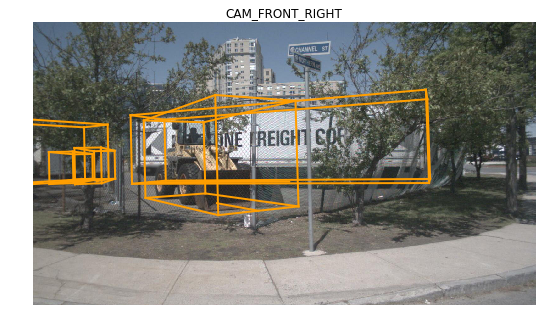

In [60]:
#3d render with original bounding boxes
#343
#369

#383
#357
sample_number =348
camera = 'CAM_FRONT_RIGHT'
my_sample = nusc.sample[sample_number]
nusc.render_sample_data(my_sample['data']['%s' %camera])
print(my_sample)
print('this is the path')

nusc.get('sample_data', 'bde261e2ea904fcd86cef6e007bdfdb4')


f1= 'samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915624869956.jpg'
f2 ='samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915624869956.jpg'

if f1 ==f2:
    print('katie')

{'token': 'd338b03161da4de88bf6ce811201b9dc', 'timestamp': 1526915624897680, 'prev': '2d493b2677f84ca190bb6c205899251a', 'next': '93a84d105d6f43e8bd906085cfaa131e', 'scene_token': 'ab6eea0e06c84f70be411a9d36636a7a', 'data': {'RADAR_FRONT': 'c23da5c986cf4200ac90f059d67aac7f', 'RADAR_FRONT_LEFT': 'dbda28549aeb44c4a44a13e9d46e0fa7', 'RADAR_FRONT_RIGHT': '89061707f0a743279c20ca466e4ed200', 'RADAR_BACK_LEFT': '7b6ac495bf6a4051a01f193d953521b6', 'RADAR_BACK_RIGHT': 'e71c291c4a074aefa057929e7651c519', 'LIDAR_TOP': '2f4941fb2abb4502a80886e9cdd5bc2c', 'CAM_FRONT': '4b0be4bb74124570b32e584d6f5c1c2a', 'CAM_FRONT_RIGHT': '2cab2f94315e47eea4e4409d7906db6b', 'CAM_BACK_RIGHT': '62cd7c8474c44384a513a027daffc04e', 'CAM_BACK': 'd89ec14dee604432b92144a99a14e00d', 'CAM_BACK_LEFT': '43f0fbf5ce8e4a62bfb840b68e13a3ae', 'CAM_FRONT_LEFT': 'fc2966ae050e4f6397063fcf6465abec'}, 'anns': ['915cf27b2ede49cc8e0483b10839e50b', '958cc76d44ba41a2bafe057e3c472a63', 'd64262ef9b0c4463b38c2507a4392e79', '6eddeca0d5f846e3beb

{'token': '2cab2f94315e47eea4e4409d7906db6b',
 'sample_token': 'd338b03161da4de88bf6ce811201b9dc',
 'ego_pose_token': '2cab2f94315e47eea4e4409d7906db6b',
 'calibrated_sensor_token': '3b878031813c47478f7c31c91e1423b4',
 'timestamp': 1526915624869956,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915624869956.jpg',
 'prev': 'ddf7c8709b314c4bbf0cd07b61efaab4',
 'next': '7f067ae8942d4b519bf9a2e2f7f4bb01',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT_RIGHT'}

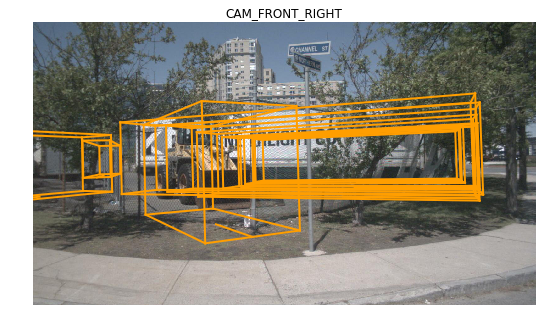

In [57]:
sample_number =374
camera = 'CAM_FRONT_RIGHT'
my_sample = nusc.sample[sample_number]
nusc.render_sample_data(my_sample['data']['%s' %camera])
print(my_sample)

#'5eedbe17cf2f44e2829567eeeb12f569'

print('this is the path')

nusc.get('sample_data', '2cab2f94315e47eea4e4409d7906db6b')



In [ ]:
#import xml.etree.cElementTree as ET
from lxml import etree as ET
root = ET.Element("annotation")


ET.SubElement(root, "folder").text = "captures_vlc"
ET.SubElement(root, "filename").text = "katie.jpg"
ET.SubElement(root, "path").text = "katie.jpg"

source = ET.SubElement(root, "source")
ET.SubElement(source, "database").text = "nuTonomy-nuscenes"

size = ET.SubElement(root, "size")
ET.SubElement(size, "width").text="Katie"
ET.SubElement(size,"height").text="Kates"
ET.SubElement(size,"depth").text="KM"
ET.SubElement(root, "segmented").text = "0"

ob= ET.SubElement(root, "object")
ET.SubElement(ob,"name").text="ball"
ET.SubElement(ob,"pose").text="Unspecified"
ET.SubElement(ob, "truncated").text="truncated"
ET.SubElement(ob, "difficult").text="0"

bb = ET.SubElement(ob,"bndbox")
ET.SubElement(bb,"xmin").text="xmin"
ET.SubElement(bb,"ymin").text="ymin"
ET.SubElement(bb,"xmax").text="xmax"
ET.SubElement(bb,"ymax").text="ymax"


tree = ET.ElementTree(root)
tree.write("%s.xml" %name,pretty_print=True)